# ISOMAP 
- ISOMAP은 pca와 mds의 주요 특징을 합친 방법으로 비선형 차원 축소 방법론에 해당합니다.
- mds의 경우 포인트간의 pair distance가 저 차원에서도 유지 되도록 하는 것이 목적입니다.
- ISOMAP도 마찬가지 이며 MDS와의 차이점으로는 점간의 거리를 유클리디안 거리를 사용하는 것이 아닌 모든 점 사이의 측지선 거리를 유지하며 더 낮은 차원에서의 매핑을 하는 것을 목적으로 합니다.
- 정리하면 ISOMAP은 원 공간에서 nearest neighbors graph를 만든 뒤 이 그래프에서의 최단 경로로 점들 간의 거리를 정의 합니다. 그리고 이 거리 정보를 최대한 보존하는 저 차원 공간으로 매핑을 합니다.

**과정**

    - step 1과 2를 통해 manifold 상에서 두 점 사이의 실제 도달 거리를 찾는 것이 목적
    - 그 거리를 이용해 MDS 진행

1. 인접한 이웃 그래프 구축 - Distance 계산

    - 매니폴드 상에서 점들이 서로 가까이 위치하는지를 측정
    - 측정하는 방식엔 두가지가 있음
        1. $\epsilon-Isomap$ : 특정 기준값 보다 가까운 경우 모두 연결 
        2. $k-Isomap$ : knn 방식으로 k개의 가장 가까운 점들 연결 

2. 두 점 간의 최단 경로 그래프 계산 - Distance Matrix 생성

    - 두 점 i와 j에 대해 두 점이 서로 연결되어 있다면 $d_G(i,j) = d_x(i,j)$
    - 두 점 i와 j에 대해 두 점이 서로 연결되어 있지 않다면 무한으로 초기화
    - 노드간의 최단 거리를 찾는 알고리즘을 통해 distance 정보 update
    - 이를 이용해 MDS를 수행 가능한 distance matrix 생성

3. MDS를 이용해 d차원 임베딩 구축

## 데이터 로드 

In [3]:
from sklearn.datasets import load_digits
import numpy as np 
from tqdm import tqdm 
import pandas as pd 
import matplotlib.pyplot as plt 
import warnings 

warnings.filterwarnings('ignore')

data = load_digits()
input_x = data.data
input_y = data.target
#계산 용이성을 위해 minmax 진행 
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
input_x = minmax.fit_transform(input_x).astype(np.float16)


## step 1 : 인접한 이웃 - Distance 계산 

In [5]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=20,
                        algorithm='auto',
                        metric = 'minkowski',
                        p = 2).fit(input_x)                    

## Step 2 : shorted Distance Graph 구축 

In [7]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import connected_components
from scipy.sparse.csgraph import shortest_path
nbg = kneighbors_graph(
    nbrs,
    n_neighbors=20,
    metric = 'minkowski',
    p= 2,
    mode="distance"
)
n_conntected_components, labels = connected_components(nbg)
dist_matrix_ = shortest_path(nbg, method='auto', directed=False)
G = dist_matrix_**2
G *= -0.5 


## Step 3 : MDS 또는 Kernel PCA 를 이용해 d차원 임베딩 매핑 후 시각화 

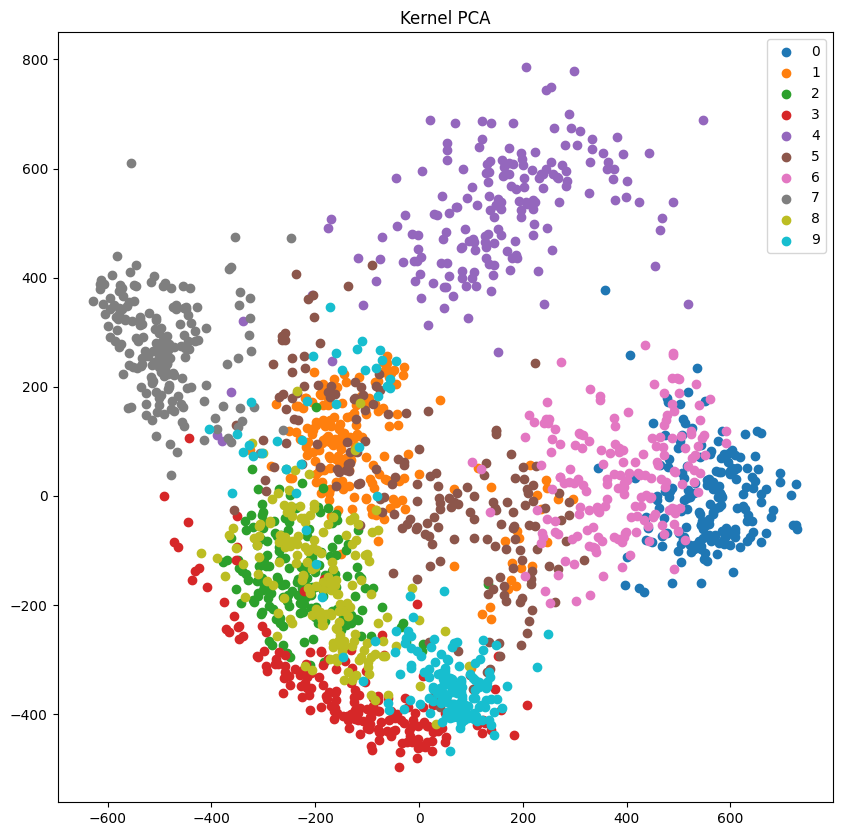

In [8]:
import matplotlib.pyplot as plt 
from sklearn.decomposition import KernelPCA
kpca = KernelPCA()
pca_x = kpca.fit_transform(G)
plt.figure(figsize=(10,10))
for i in range(10):
    plt.scatter(pca_x[input_y==i][:,0],
                pca_x[input_y==i][:,1],
                label = i)
    plt.legend()
plt.title("Kernel PCA")
plt.show()                    

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_mds.py:517: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


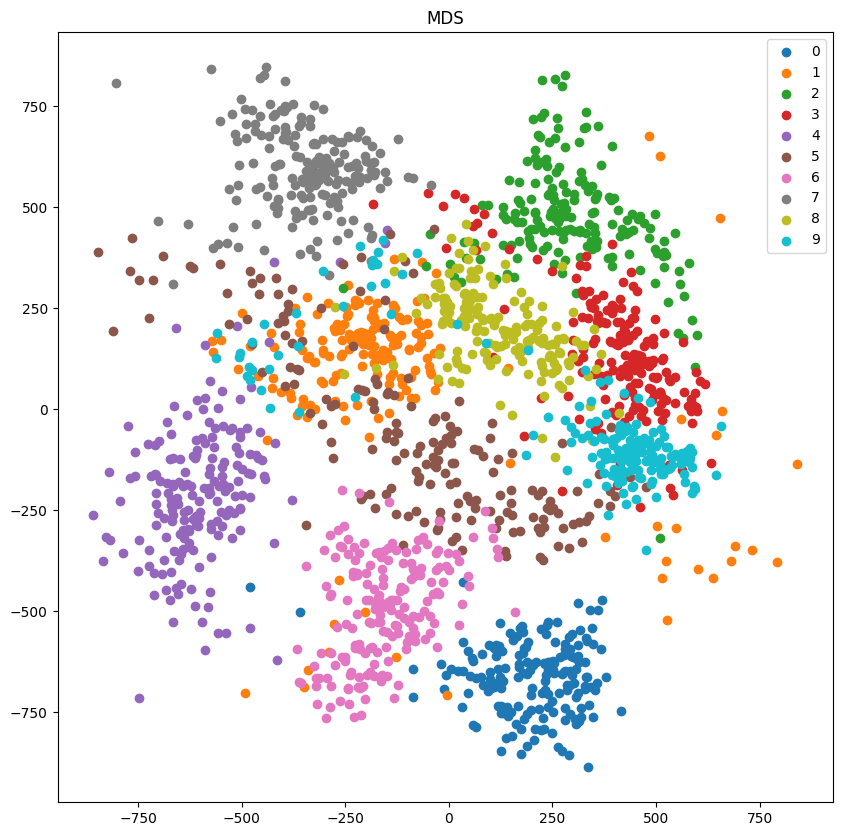

In [9]:
import matplotlib.pyplot as plt 
from sklearn.manifold import MDS 

mds = MDS()
mds_x = mds.fit_transform(G)

plt.figure(figsize=(10,10))
for i in range(10):
    plt.scatter(mds_x[input_y==i][:,0],
                mds_x[input_y==i][:,1],
                label = i)
    plt.legend()
plt.title("MDS")    
plt.show()                    

c:\Users\dags8\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\dags8\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


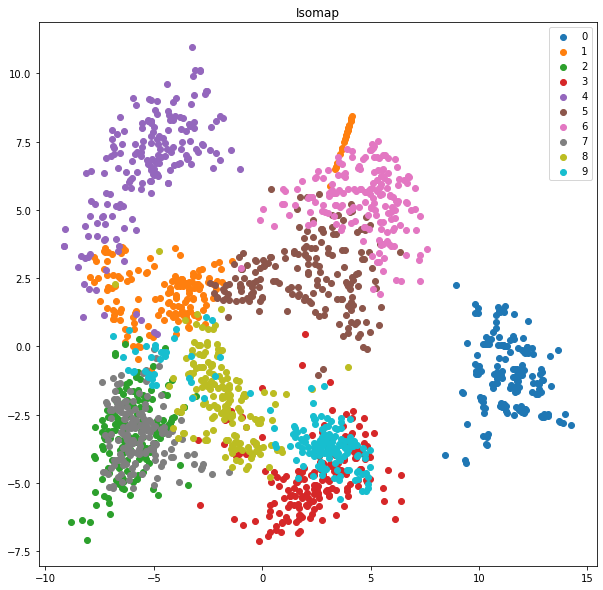

In [153]:
from sklearn.manifold import Isomap
isomap = Isomap()
mds_x = isomap.fit_transform(input_x)

plt.figure(figsize=(10,10))
for i in range(10):
    plt.scatter(mds_x[input_y==i][:,0],
                mds_x[input_y==i][:,1],
                label = i)
    plt.legend()
plt.title("Isomap")    
plt.show()            

# LLE 
- LLE 알고리즘은 ISOAMP과 마찬가지로 manifold learning의 일종으로 Unsupervised 방식이지 non linear 방식이다 
- 기존 데이터의 structure를 유지하는 형태로 학습되며 두가지 가정 하에 차원 축소가 가능 하다 
    - 데이터 포인트의 neighborhood 포인트가 최소 20개 이상이어야 하며 
    - 데이터의 분포가 급격하게 변하거나 특정 부분에 없을 경우 좋지 않다 

**과정**
- 과정은 ISOMAP과 유사하다 
1. Neighborhood graph 생성 
2. Weight matrix 계산 
    - 각 데이터 포인트는 neighborhood 포인트들이 가중 합으로 계산된다. 
    - 이 neighborhood 포인트들의 가중치를 학습하는 것이고 이웃이 아닌 포인트들의 가중치는 0이다. 
    - 이웃의 가중치만 사용하기 때문에 Locally라는 이름을 가지며 이웃 포인트들의 가중치를 선형 계수로 사용하기에 linear라는 이름을 갖는다. 
3. Embedding 
    - 두 번째 단계에서 구해진 weight를 이용해 저차원으로 매핑을 진행한다. 

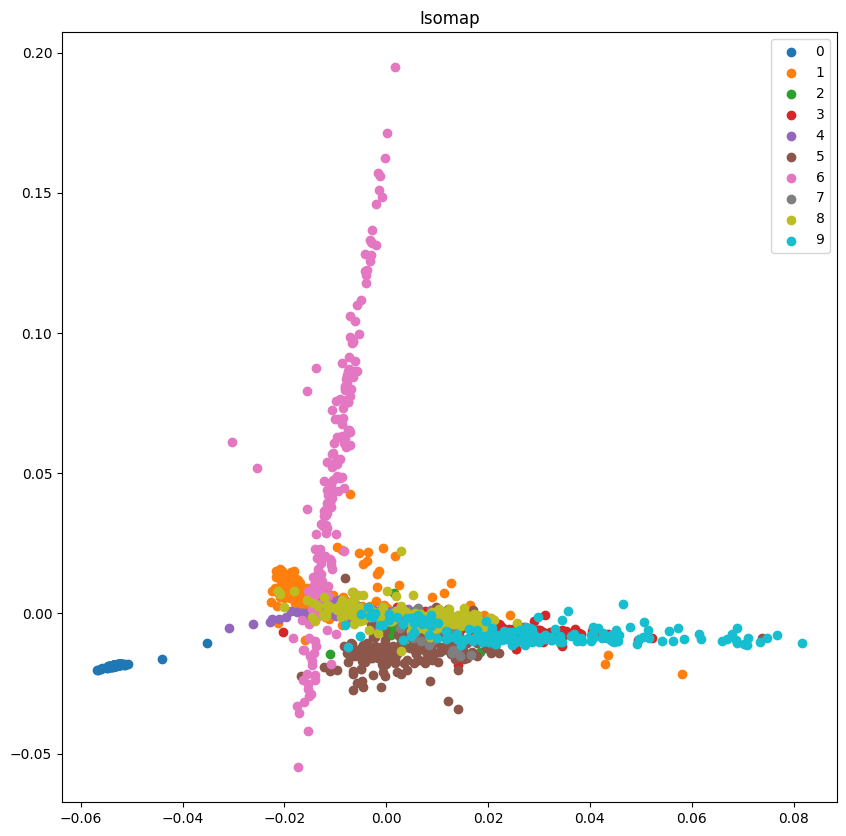

In [19]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_neighbors=n_neighbors,
                            n_components = 2,
                            eigen_solver = 'auto',
                            method='standard',)
mds_x = lle.fit_transform(input_x)

plt.figure(figsize=(10,10))
for i in range(10):
    plt.scatter(mds_x[input_y==i][:,0],
                mds_x[input_y==i][:,1],
                label = i)
    plt.legend()
plt.title("Isomap")    
plt.show()            

# t-SNE 
**SNE**
- SNE는 Stochastic Neighbor Embedding의 약자로 고차원의 데이터를 저차원으로 임베딩 할 때 ISOMAP과 LLE와 마찬가지로 neighborhood structure를 유지하고자 한다. 
- 각 데이터 포인트마다 가우시안 분포를 이용해 neighborhood의 확률값을 사용하는 것이 ISOMAP과 LLE 간의 차이라고 할 수 있다. 
- 이 확률값을 저차원으로 차원 축소하면서 최대한 유지하고자 하는 것이 목적이다. 
- 고차원에서의 이웃의 확률 분포를 $P$, 저차원에서의 이웃의 확률 분포를 $q$라고 할 때 $P$와 $q$간의 KL Divergence를 최소화 하는 파라미터를 찾고자 한다. 

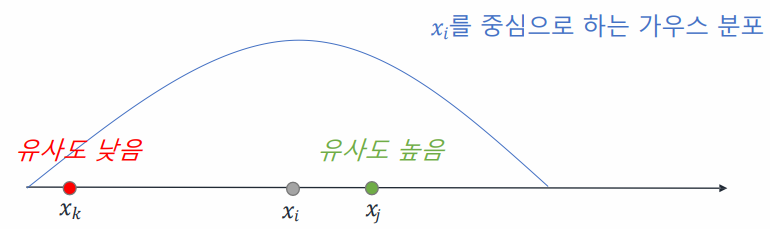



**t-SNE** 
- SNE에는 문제가 존재하는데 **Crowding Problem**이 발생한다는 점이다. 
- 데이터를 저차원으로 축소했을 때 각 포인트들이 너무 밀집되어 구분이 어려운 문제이다. 
- SNE는 가우시안 분포를 사용하기 때문에 분포에서 멀어질 수록 확률 밀도 값이 급격히 떨어지기 때문에 해당 문제가 발생한다. 
- 따라서 가우시안 분포 대신 확률 밀도 값이 급격히 떨어지지 않는 t분포를 사용한 것이 **t-SNE** 이다. 

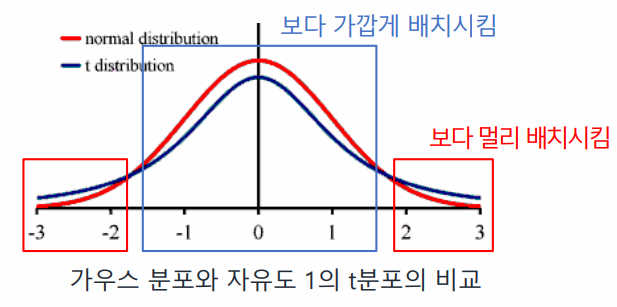

- t-SNE의 장점은 군집이 중복되지 않는다는 점이다. 
- 그렇기 때문에 시각화에 굉장히 유용한데 지역적인 구조를 잘 잡아내는 동시에 전역적인 특징 역시 잘 잡는다는 장점이 있다. 

In [24]:
import numpy as np

def neg_distance(X):
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return -D
def softmax(X):
    e_x = np.exp(X - np.max(X, axis=1).reshape([-1, 1]))
    np.fill_diagonal(e_x, 0.)
    e_x = e_x + 1e-8
    return e_x / e_x.sum(axis=1).reshape([-1, 1])
def calc_prob_matrix(distances, sigmas=None):
    if sigmas is not None:
        two_sig_sq = 2. * np.square(sigmas.reshape((-1, 1)))
        return softmax(distances / two_sig_sq)
    else:
        return softmax(distances)
def _perplexity(prob_matrix):
    entropy = -np.sum(prob_matrix * np.log2(prob_matrix), 1)
    perplexity = 2 ** entropy
    return perplexity
def perplexity(distances, sigmas):
    return _perplexity(calc_prob_matrix(distances, sigmas))
def binary_search(fn, target, tol=1e-10, max_iter=10000,
                  lower=1e-20, upper=1000.):
    for i in range(max_iter):
        guess = (lower + upper) / 2.
        val = fn(guess)
        if val > target:
            upper = guess
        else:
            lower = guess
        if np.abs(val - target) <= tol:
            break
    return guess
def find_optimal_sigmas(distances, target_perplexity):
    sigmas = []
    for i in range(distances.shape[0]):
        fn = lambda sigma: \
            perplexity(distances[i:i+1, :], np.array(sigma))
        correct_sigma = binary_search(fn, target_perplexity)
        sigmas.append(correct_sigma)
    return np.array(sigmas)
def p_conditional_to_joint(P):
    return (P + P.T) / (2. * P.shape[0])
def q_joint(Y):
    inv_distances = neg_distance(Y)**0.5
    distances = np.power(1., -inv_distances,-1)
    np.fill_diagonal(distances, 0.)
    return distances / np.sum(distances), distances
def p_joint(X, target_perplexity):
    distances = neg_distance(X)
    sigmas = find_optimal_sigmas(distances, target_perplexity)
    p_conditional = calc_prob_matrix(distances, sigmas)
    P = p_conditional_to_joint(p_conditional)
    return P
def tsne_grad(P, Q, Y, distances):
    pq_diff = P - Q
    pq_expanded = np.expand_dims(pq_diff, 2)
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    distances_expanded = np.expand_dims(distances, 2)
    y_diffs_wt = y_diffs * distances_expanded
    grad = 4. * (pq_expanded * y_diffs_wt).sum(1)
    return grad
def t_SNE(X, num_component, num_iters = 500, learning_rate = 10., momentum = .9):
    Y = np.random.normal(0., 0.0001,[X.shape[0], num_component])
    P = p_joint(X, 20)
    if momentum:
        Y_m2 = Y
        Y_m1 = Y
    for i in range(num_iters):
        Q, distances = q_joint(Y)
        grads = tsne_grad(P, Q, Y, distances)
        Y = Y - learning_rate * grads
        if momentum:
            Y += momentum * (Y_m1 - Y_m2)
            Y_m2 = Y_m1
            Y_m1 = Y
    return Y

In [ ]:
from sklearn import (datasets)
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox

digits = datasets.load_digits(n_class=5)
X = digits.data
y = digits.target
n_samples, n_features = X.shape

def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
print("Computing t_SNE embedding")
t0 = time()
embedding = t_SNE(X = X, num_component = 2)

plot_embedding(embedding,"t_SNE projection of the digits (time %.2fs)" %(time() - t0))

## t-SNE 라이브러리 

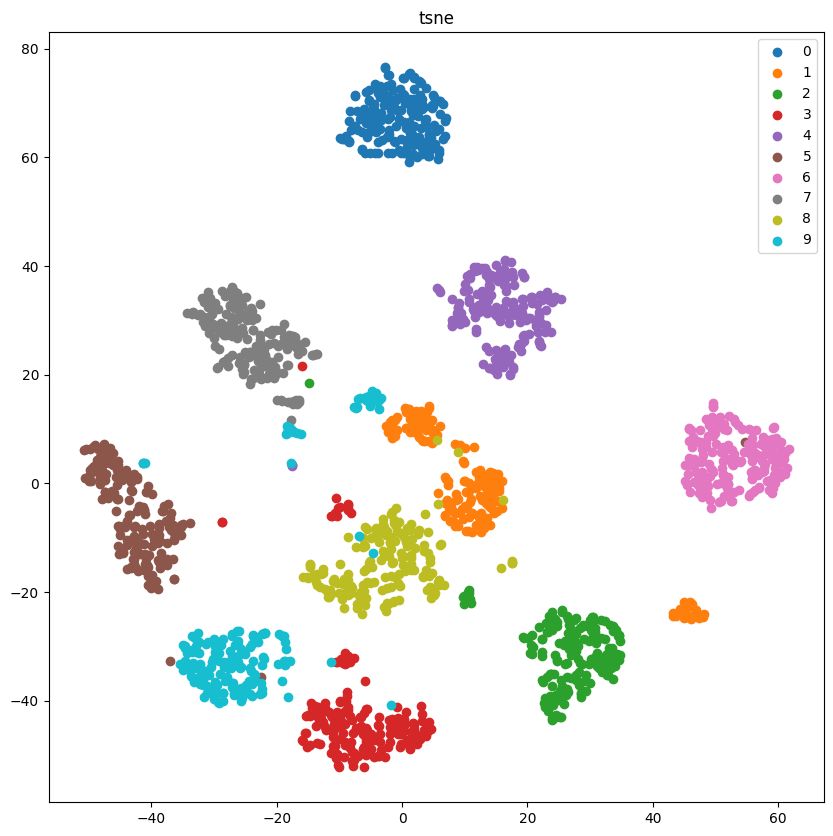

In [29]:
from sklearn.manifold import TSNE
tsne = TSNE()
mds_x = tsne.fit_transform(input_x)

plt.figure(figsize=(10,10))
for i in range(10):
    plt.scatter(mds_x[input_y==i][:,0],
                mds_x[input_y==i][:,1],
                label = i)
    plt.legend()
plt.title("tsne")    
plt.show()            

# Isomap vs LLE vs tSNE 비교 
- 라이브러리 사용 

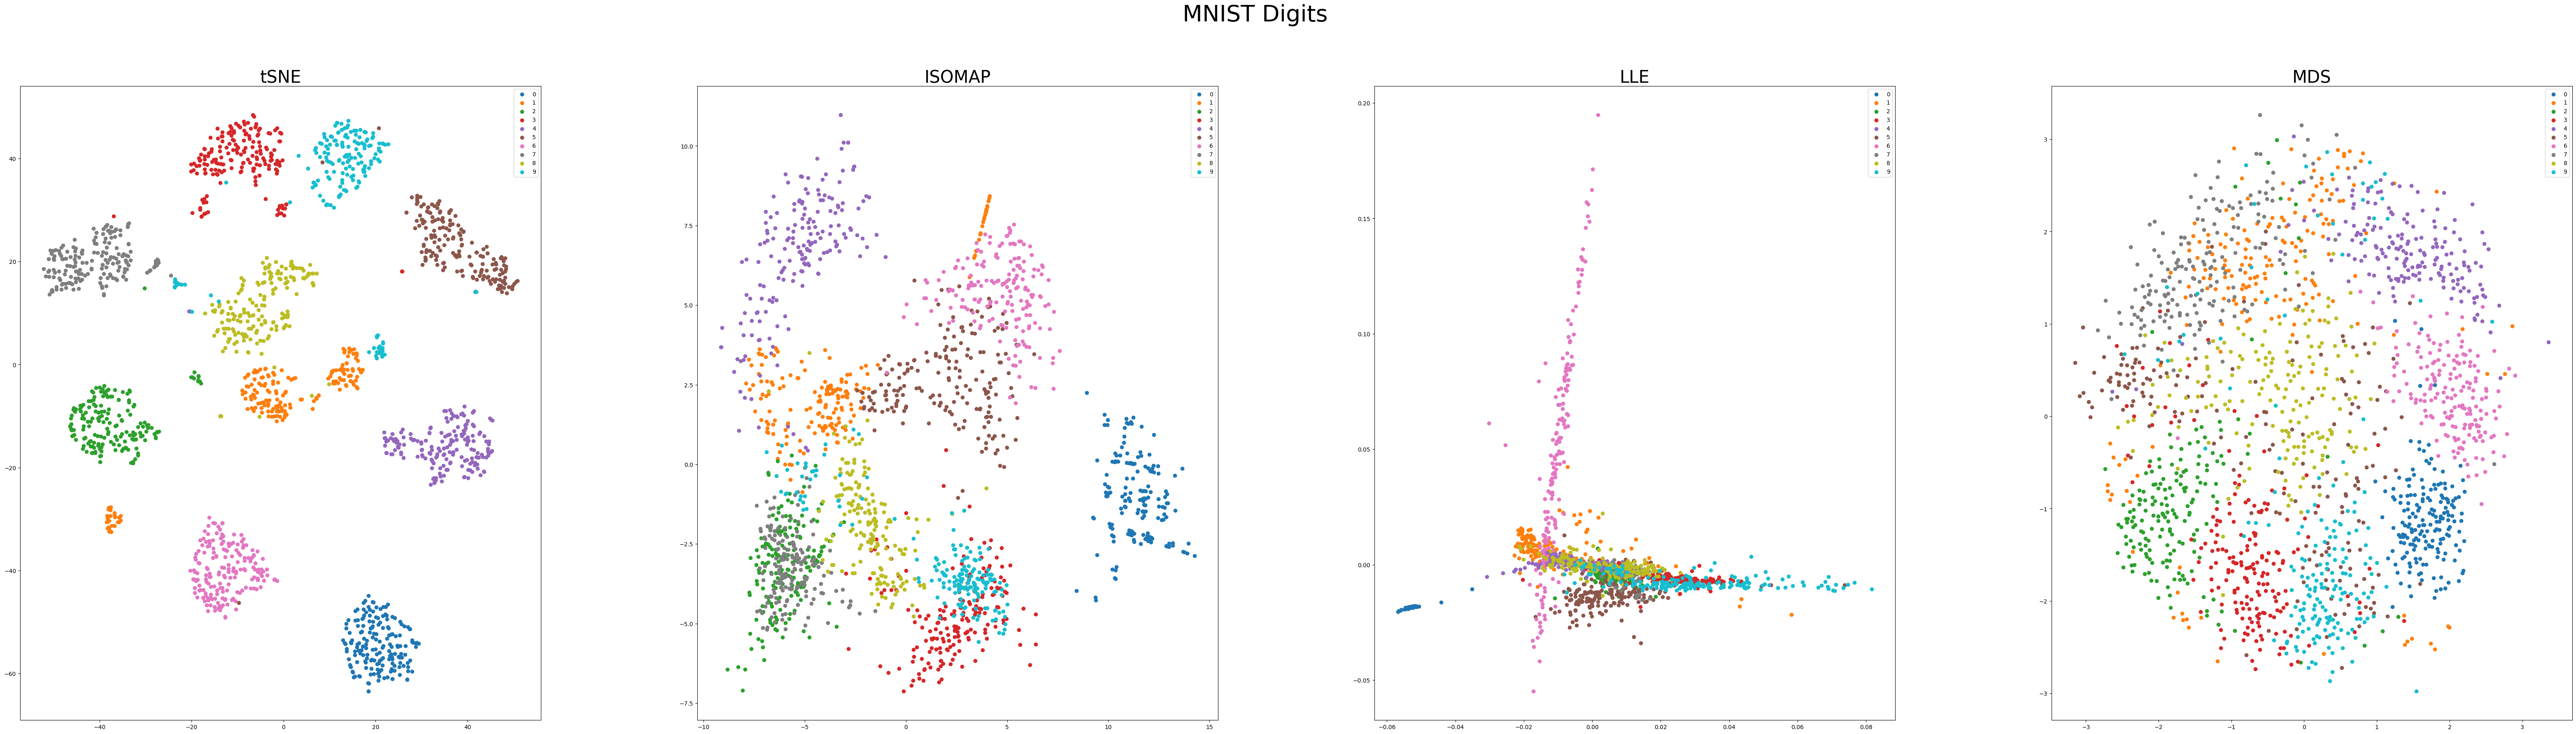

In [37]:
class method_class:
    MDS = MDS(n_components=2)
    tSNE = TSNE()
    ISOMAP = Isomap()
    LLE = LocallyLinearEmbedding(n_neighbors=20,
                            n_components = 2,
                            eigen_solver = 'auto',
                            method='standard',)
                            
def plot_nonlinear_embedding(embed,input_x,input_y,Title,axes):
    embed_x = embed.fit_transform(input_x)
    for i in range(10):
        axes.scatter(embed_x[input_y==i][:,0],
                    embed_x[input_y==i][:,1],
                    label = i)
        axes.legend()
    axes.set_title(Title,fontsize=30)
                                          
from sklearn.manifold import TSNE,Isomap,LocallyLinearEmbedding,MDS
f, axes = plt.subplots(1,4,figsize=(80,20))
f.set_size_inches((80, 20))
f.suptitle('MNIST Digits', fontsize = 40)
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i,title in enumerate(['tSNE','ISOMAP','LLE','MDS']):
    exec(f'method = method_class.{title}')
    plot_nonlinear_embedding(embed = method,
                            input_x = input_x,
                            input_y = input_y,
                            Title = title,
                            axes = axes[i])